## District Maps

You can learn how to plot a map and include attributes of the map (from shapefile.dbf file) in the map here: http://basemaptutorial.readthedocs.io/en/latest/shapefile.html

But it will be challenging to interpret the fields in the map.<shapefilename>_info list of dictionary entries.

For my shape file, this is what an element in the list looked like:
{‘STATEFP’: ‘41’, ‘CD115FP’: ‘02’, ‘AFFGEOID’: ‘5001500US4102’, ‘GEOID’: ‘4102’, ‘LSAD’: ‘C2’, ‘CDSESSN’: ‘115’, ‘ALAND’: 179860036894, ‘AWATER’: 1904464066, ‘RINGNUM’: 1, ‘SHAPENUM’: 163}

I learned in a site for journalists that I could load my shape file as a Google Fusion table here: https://www.poynter.org/news/journalists-guide-mapping-data-county-district-using-shpescape

When my Google Fusion table was loaded with the shape file, it was a lot easier to understand how the polygons are defined in the shape file, and how each polygon is associated with attributes in the .dbf, accessible via map.<shapefilename>_info list.

You can see the Google Fusion table loaded with my shapefile here https://www.google.com/fusiontables/DataSource?docid=1eZdzB_Vpf7ZnFkUyNEpkpM2o3q8Ebn00k9yE2VG2

USA states coordinates here: http://www.ala.org/rt/magirt/publicationsab/usa

In [121]:
import numpy as np
import pandas as pd
from scipy.ndimage.measurements import center_of_mass
import warnings
warnings.filterwarnings('ignore')

In [31]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.patches import PathPatch
from mpl_toolkits.basemap import Basemap
%matplotlib inline

In [172]:
fpstate = {'01': 'AL', '02': 'AK', '60': 'AS', '04': 'AZ', '05': 'AR', '06': 'CA', '08': 'CO', '09': 'CT',
'10': 'DE', '11': 'DC', '12': 'FL', '64': 'FM', '13': 'GA', '66': 'GU', '15': 'HI', '16': 'ID',
'17': 'IL', '18': 'IN', '19': 'IA', '20': 'KS', '21': 'KY', '22': 'LA', '23': 'ME', '68': 'MH', 
'24': 'MD', '25': 'MA', '26': 'MI', '27': 'MN', '28': 'MS', '29': 'MO', '30': 'MT', '31': 'NE',
'32': 'NV', '33': 'NH', '34': 'NJ', '35': 'NM', '36': 'NY', '37': 'NC', '38': 'ND', '69': 'MP',
'39': 'OH', '40': 'OK', '41': 'OR', '70': 'PW', '42': 'PA', '72': 'PR', '44': 'RI', '45': 'SC',
'46': 'SD', '47': 'TN', '48': 'TX', '74': 'UM', '49': 'UT', '50': 'VT', '51': 'VA', '78': 'VI',
'53': 'WA', '54': 'WV', '55': 'WI', '56': 'WY'}
statefp = {'AL': '01', 'AK': '02', 'AS': '60', 'AZ': '04', 'AR': '05', 'CA': '06', 'CO': '08', 'CT': '09',
'DE': '10', 'DC': '11', 'FL': '12', 'FM': '64', 'GA': '13', 'GU': '66', 'HI': '15', 'ID': '16',
'IL': '17', 'IN': '18', 'IA': '19', 'KS': '20', 'KY': '21', 'LA': '22', 'ME': '23', 'MH': '68',
'MD': '24', 'MA': '25', 'MI': '26', 'MN': '27', 'MS': '28', 'MO': '29', 'MT': '30', 'NE': '31', 
'NV': '32', 'NH': '33', 'NJ': '34', 'NM': '35', 'NY': '36', 'NC': '37', 'ND': '38', 'MP': '69',
'OH': '39', 'OK': '40', 'OR': '41', 'PW': '70', 'PA': '42', 'PR': '72', 'RI': '44', 'SC': '45',
'SD': '46', 'TN': '47', 'TX': '48', 'UM': '74', 'UT': '49', 'VT': '50', 'VA': '51', 'VI': '78', 
'WA': '53', 'WV': '54', 'WI': '55', 'WY': '56'}
# state coordinates to create map: llcrnrlon, urcrnrlon, urcrnrlat, llcrnrlat
state_coordinates = {'AL': (-88.50,-84.87,35.00,30.25), 'AK': (173.50,-130.00,71.50,51.25),
'AZ': (-114.87,-109.00,37.00,31.33), 'AR': (-94.62,-89.62,36.50,33.00),
'CA': (-124.42,-114.12,42.00,32.53), 'CO': (-109.12,-102.00,41.00,37.00),
'CT': (-73.75,-71.75,42.05,41.00), 'DE': (-75.80,-75.00,39.85,38.45),
'DC': (-77.12,-76.87,39.00,38.87), 'FL': (-87.62,-79.8,31.00,24.4),
'GA': (-85.62,-80.75,35.00,30.35), 'HI': (-160.25,-154.75,22.23,18.87),
'ID': (-117.25,-111.00,49.00,42.00), 'IL': (-91.50,-87.50,42.50,37.00),
'IN': (-88.12,-84.75,41.75,37.87), 'IA': (-96.62,-90.12,43.50,40.37),
'KS': (-102.50,-94.58,40.00,37.00), 'KY': (-89.58,-81.95,39.15,36.62),
'LA': (-94.05,-88.82,33.02,28.92), 'ME': (-71.13,-66.88,47.47,42.97),
'MD': (-79.50,-75.00,39.75,37.87), 'MA': (-73.52,-69.92,42.87,41.22),
'MI': (-90.50,-82.37,48.28,41.70), 'MN': (-97.25,-89.50,49.38,43.50),
'MS': (-91.63,-88.12,35.00,30.00), 'MO': (-95.78,-89.10,40.62,36.00), 
'MT': (-116.05,-104.03,49.00,44.37), 'NE': (-104.05,-95.32,43.00,40.00),
'NV': (-120.00,-114.05,42.00,35.00), 'NH': (-72.57,-70.58,45.35,42.70),
'NJ': (-75.55,-73.87,41.37,38.92), 'NM': (-109.05,-103.00,37.00,31.33),
'NY': (-79.77,-71.87,45.02,40.50), 'NC': (-84.33,-75.42,36.60,33.85),
'ND': (-104.05,-96.55,49.00,45.93), 'OH': (-84.82,-80.52,42.00,38.40),
'OK': (-103.00,-94.43,37.00,33.62), 'OR': (-124.58,-116.45,46.27,41.90),
'PA': (-80.52,-74.68,42.27,39.72), 'PR': (-67.95,-65.22,18.53,17.92),
'RI': (-71.92,-71.12,42.02,41.13), 'SC': (-83.37,-78.52,35.22,32.00),
'SD': (-104.05,-96.43,45.93,42.48), 'TN': (-90.32,-81.63,36.68,34.97),
'TX': (-106.5,-93.2,36.50,25.68), 'UT': (-114.05,-109.00,42.00,37.00),
'VT': (-73.60,-71.47,45.00,42.72), 'VA': (-83.8,-75.1,39.4,36.40),
'VI': (-83.68,-75.25,39.47,36.53), 'WA': (-124.77,-116.92,49.00,45.53),
'WV': (-82.65,-77.73,40.63,37.20), 'WI': (-92.90,-86.75,47.12,42.50), 
'WY': (-111.10,-104.00,45.00,41.00)}

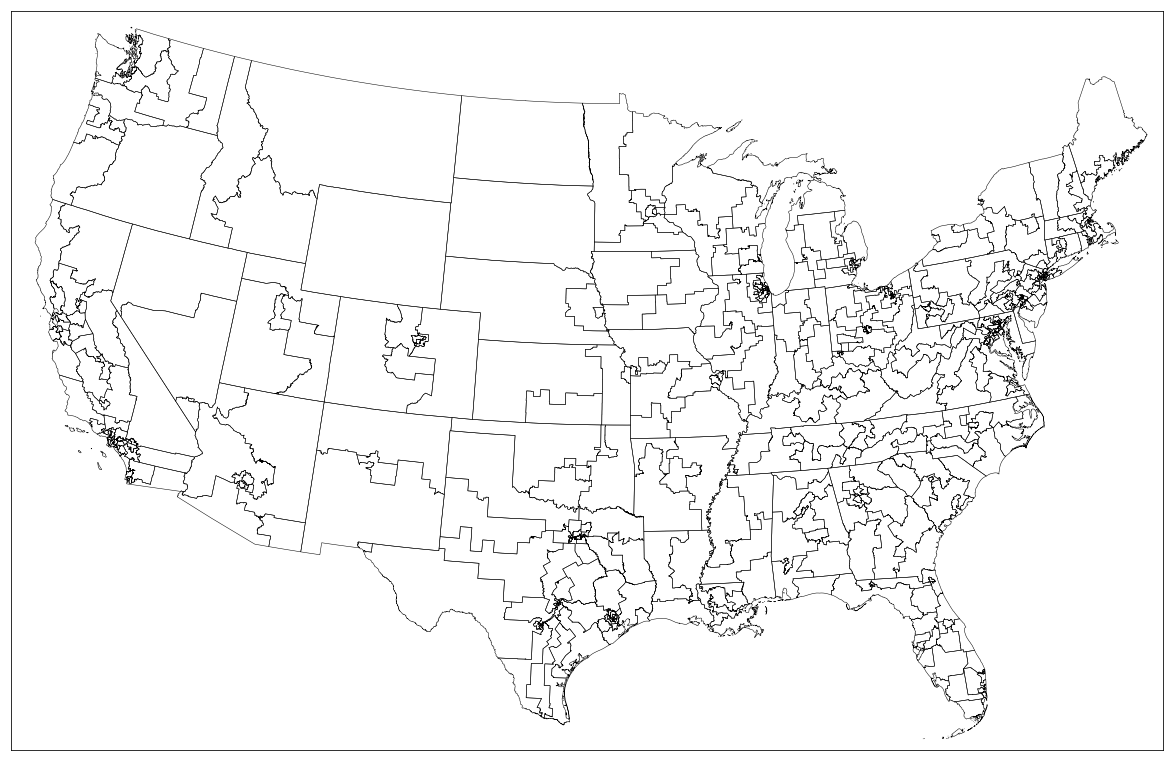

In [8]:
map = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95)

fig = plt.figure(figsize=(20,20))
ax = fig.add_axes([0.1,0.1,0.8,0.8])
_ = map.readshapefile('data/cb_2016_us_cd115_500k/cb_2016_us_cd115_500k', 'cb_2016_us_cd115_500k')

In [13]:
#statefp['OR']
#for t in map.cb_2016_us_cd115_500k_info:
#    if t['STATEFP'] == '41':
#        print(t)

In [174]:
def get_district_winner(state, district):
    if int(district)%2 == 0:
        return 'r'
    else:
        return 'b'

def print_district_map(state, state_coords, ax):
    llcrnrlon, urcrnrlon, urcrnrlat, llcrnrlat = state_coords[state]
    lat_0 = (urcrnrlat + llcrnrlat) / 2
    lon_0 = (llcrnrlon + urcrnrlon) / 2
    map = Basemap(llcrnrlon=llcrnrlon, llcrnrlat=llcrnrlat, urcrnrlon=urcrnrlon, urcrnrlat=urcrnrlat,
                  resolution='i', projection='tmerc', lat_0=lat_0, lon_0=lon_0)
    _ = map.readshapefile('data/cb_2016_us_cd115_5m/cb_2016_us_cd115_5m', 'cb_2016_us_cd115_5m')
    map.drawstates(linewidth=2)
    map.drawcountries(linewidth=2)
    map.drawmapboundary(fill_color='aqua')
    map.fillcontinents(color='#ddaa66',lake_color='aqua')
    #map.fillcontinents(color='w',lake_color='aqua')
    map.drawcoastlines()
    previous_district = ""
    first_time = True
    for info, shape in zip(map.cb_2016_us_cd115_5m_info, map.cb_2016_us_cd115_5m):
        if info['STATEFP'] == statefp[state]:
            # plot district boundary section
            x, y = zip(*shape)
            map.plot(x, y, marker=None, color='k', linewidth=0.2)
            # track coordinates for current district 
            # current district
            district = info['CD115FP']
            if first_time:
                first_time = False
                previous_district = district
                xsaved = x
                ysaved = y

            if previous_district != district:
                # fill district polygon
                patches = []
                district_full_shape = []
                _ = [district_full_shape.append(pair) for pair in zip(xsaved, ysaved)]
                patches.append( Polygon(np.array(district_full_shape), True) )
                ax.add_collection(PatchCollection(patches, facecolor= 'm', edgecolor='k', linewidths=1., zorder=2))
                _ = ax.add_collection(PatchCollection(patches,facecolor=get_district_winner(state, previous_district),\
                                                      edgecolor='k', linewidths=0.2, zorder=2))
                # annotate district number
                npx = np.array(xsaved)
                npy = np.array(ysaved)
                xcenter = npx.min() + ( npx.max()-npx.min() ) / 2
                ycenter = npy.min() + ( npy.max()-npy.min() ) / 2
                _ = ax.annotate(str(int(previous_district)), xy=(xcenter, ycenter), color='w', fontweight='bold')
                # re-initiate variables with new district info
                previous_district = district
                xsaved = x
                ysaved = y                
            else:
                xsaved = xsaved + x
                ysaved = ysaved + y
            
    # fill district polygon
    patches = []
    district_full_shape = []
    _ = [district_full_shape.append(pair) for pair in zip(xsaved, ysaved)]
    patches.append( Polygon(np.array(district_full_shape), True) )
    ax.add_collection(PatchCollection(patches, facecolor= 'm', edgecolor='k', linewidths=1., zorder=2))
    _ = ax.add_collection(PatchCollection(patches,facecolor=get_district_winner(state, previous_district),\
                                          edgecolor='k', linewidths=0.2, zorder=2))
    # annotate last district
    npx = np.array(xsaved)
    npy = np.array(ysaved)
    xcenter = npx.min() + ( npx.max()-npx.min() ) / 2
    ycenter = npy.min() + ( npy.max()-npy.min() ) / 2
    _ = ax.annotate(str(int(previous_district)), xy=(xcenter, ycenter), color='w', fontweight='bold')

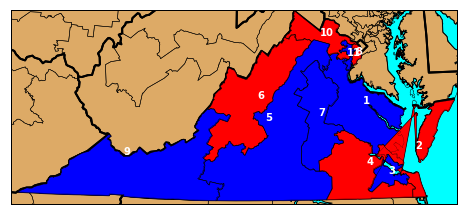

In [175]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
print_district_map('VA', state_coordinates, ax)

AL


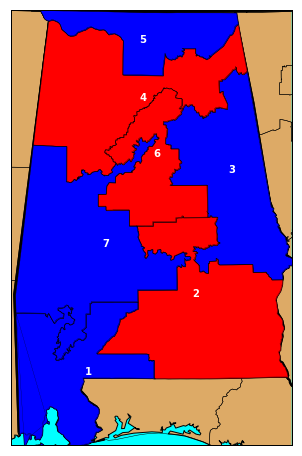

AK


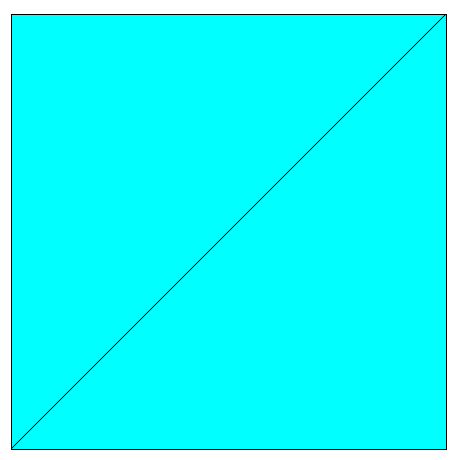

AZ


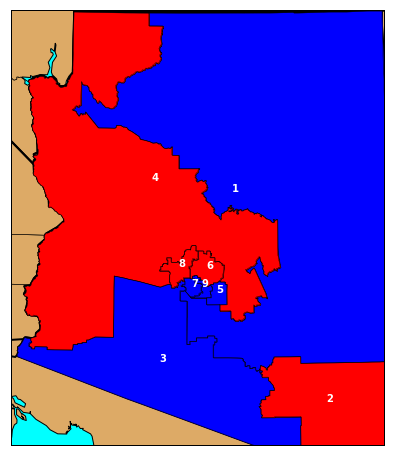

AR


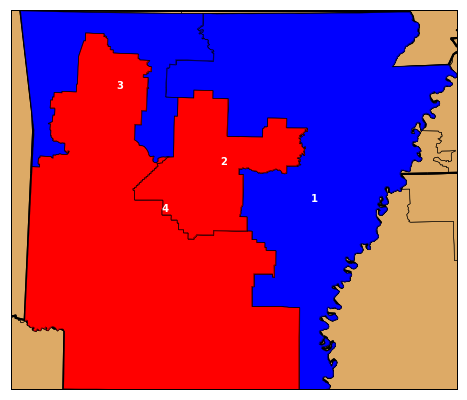

CA


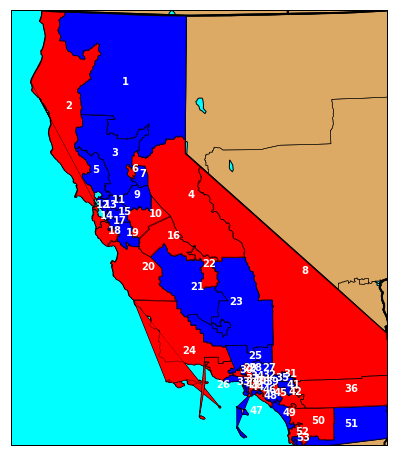

CO


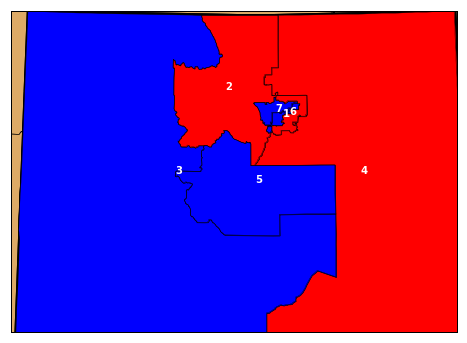

CT


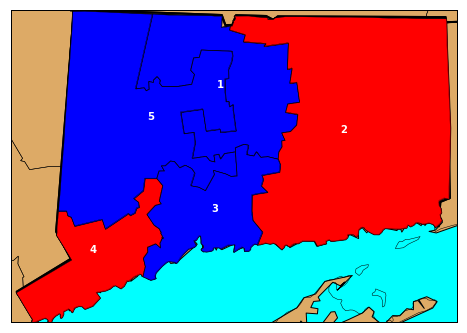

DE


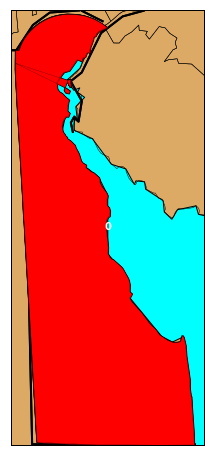

DC


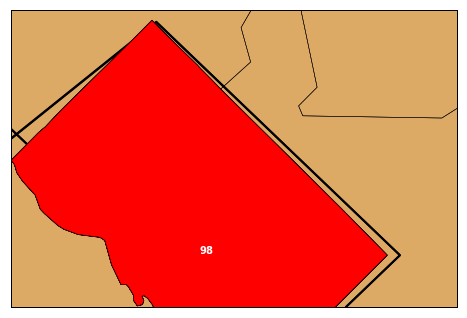

FL


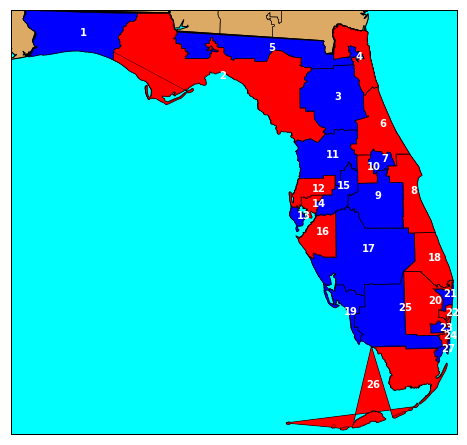

GA


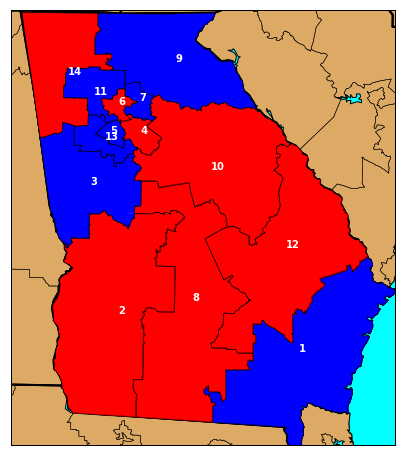

HI


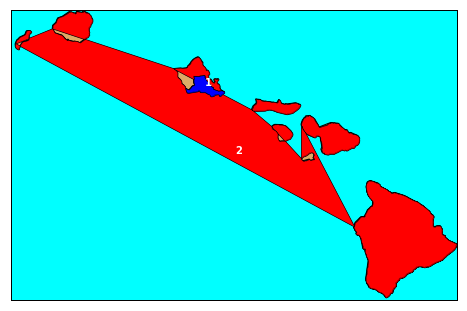

ID


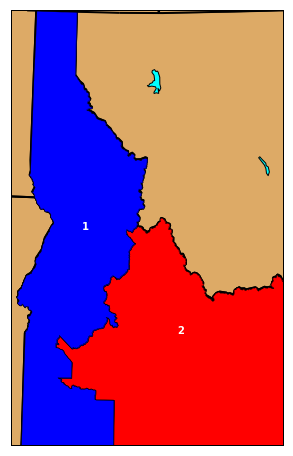

IL


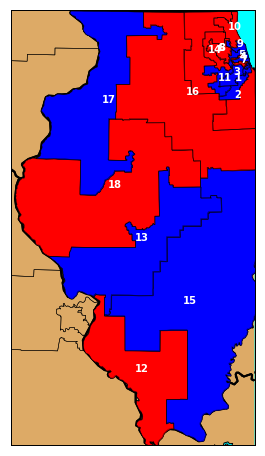

IN


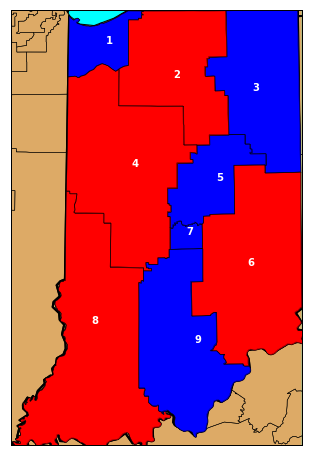

IA


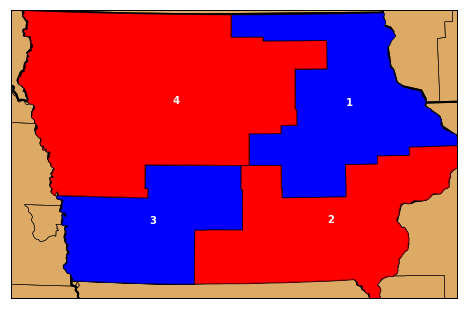

KS


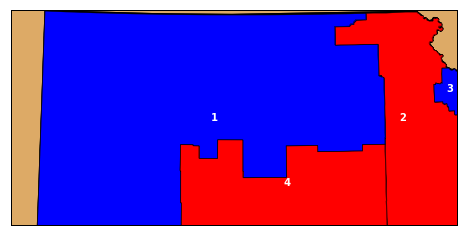

KY


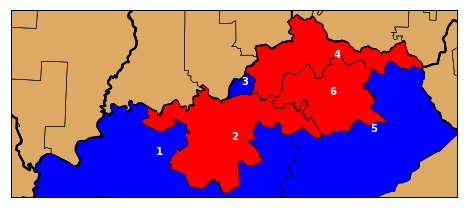

LA


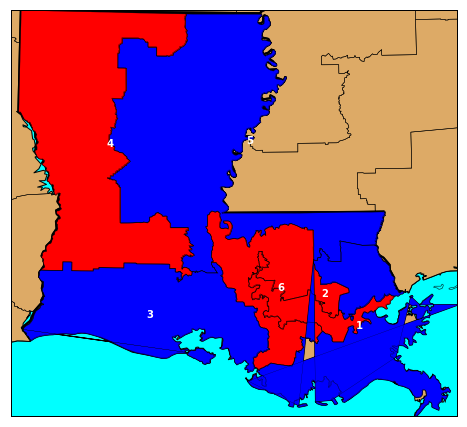

ME


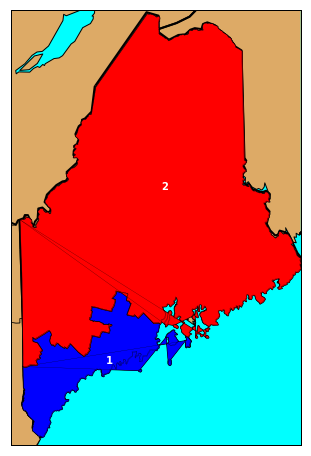

MD


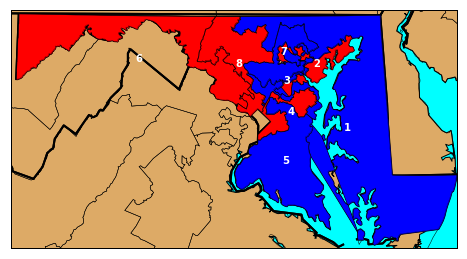

MA


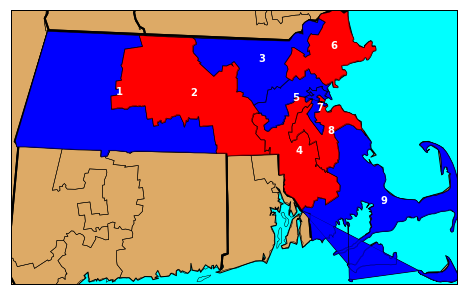

MI


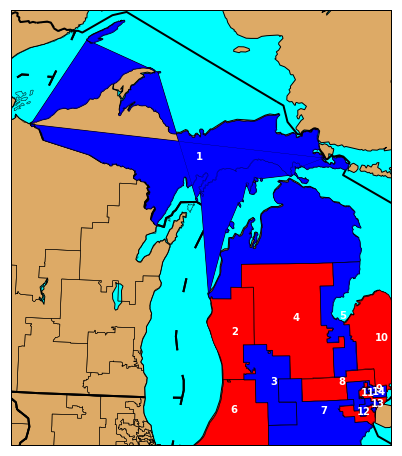

MN


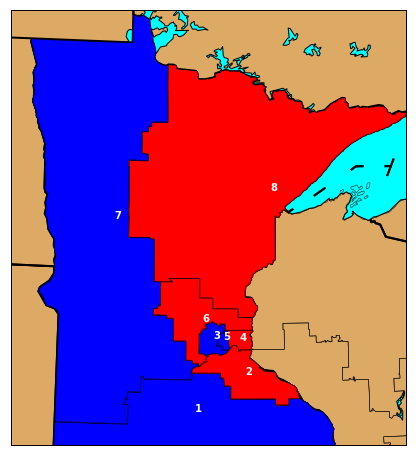

MS


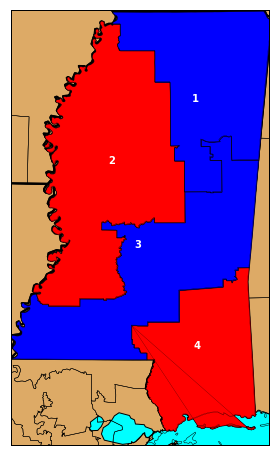

MO


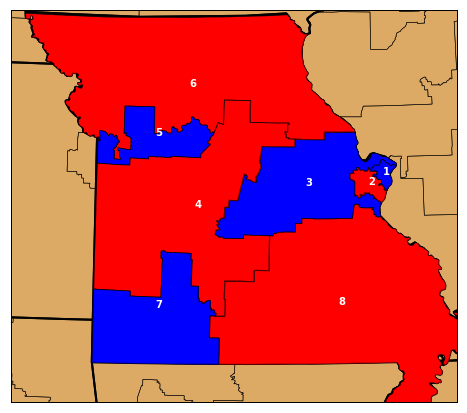

MT


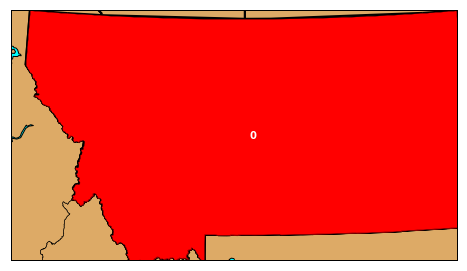

NE


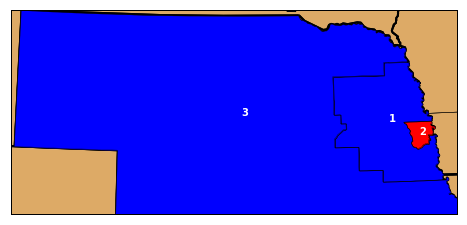

NV


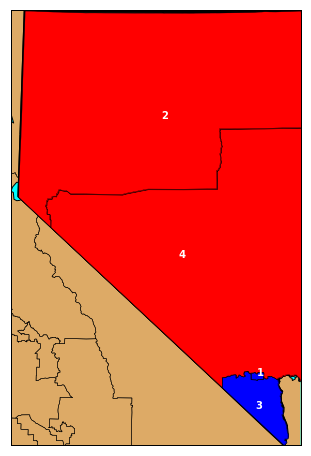

NH


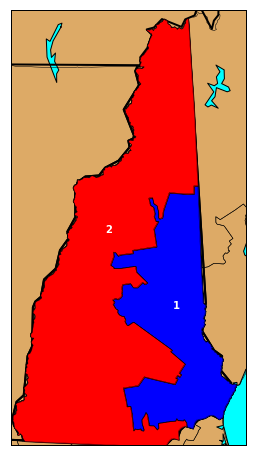

NJ


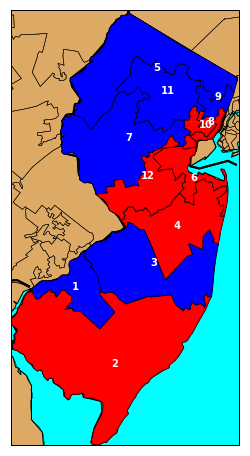

NM


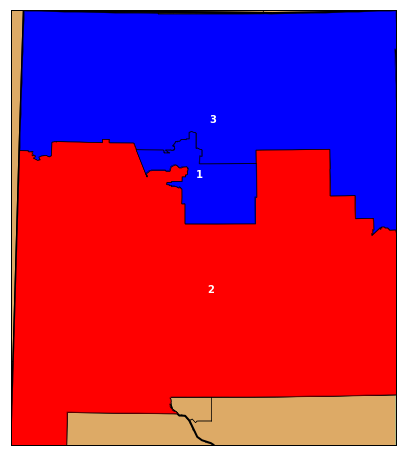

NY


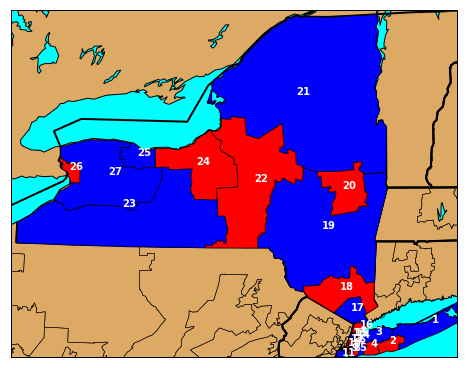

NC


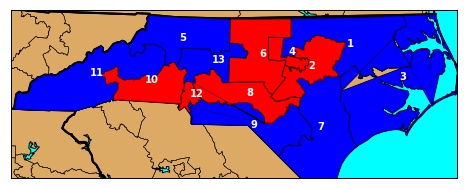

ND


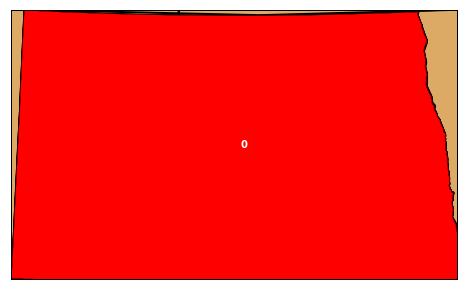

OH


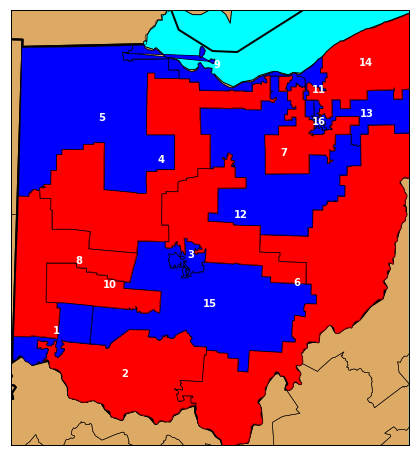

OK


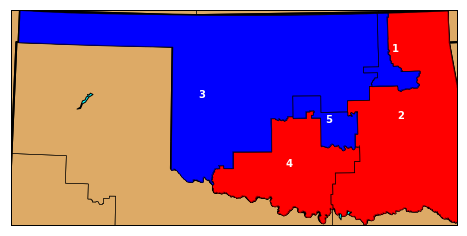

OR


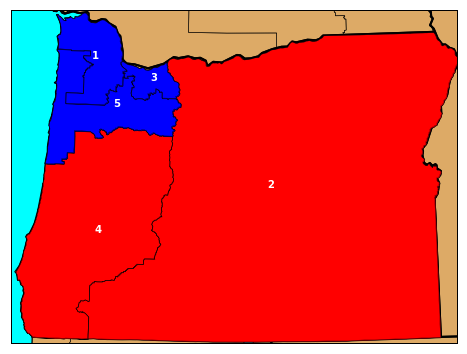

PA


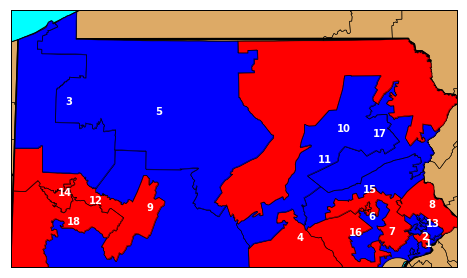

PR


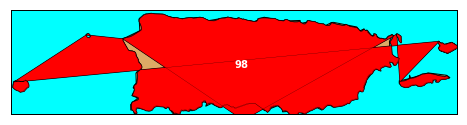

RI


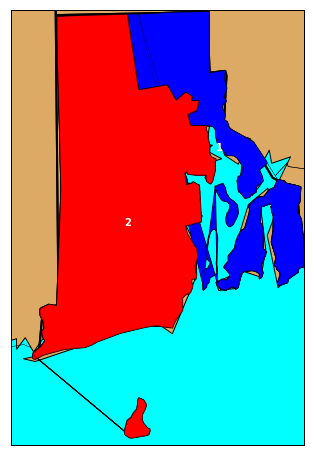

SC


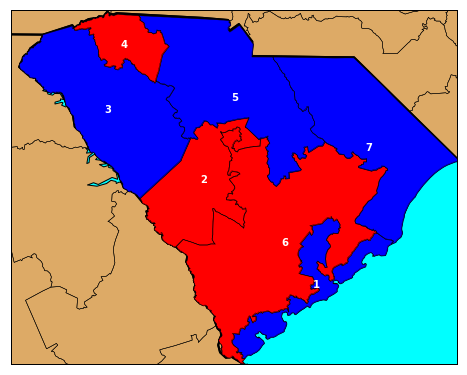

SD


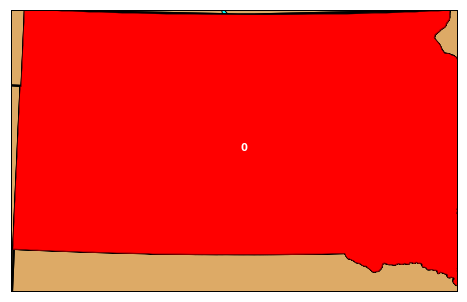

TN


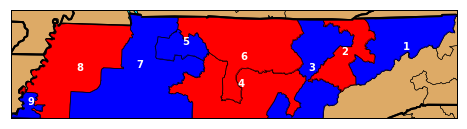

TX


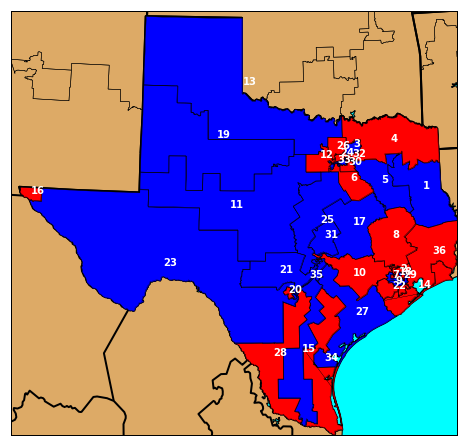

UT


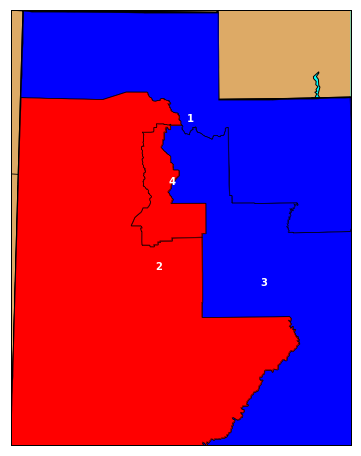

VT


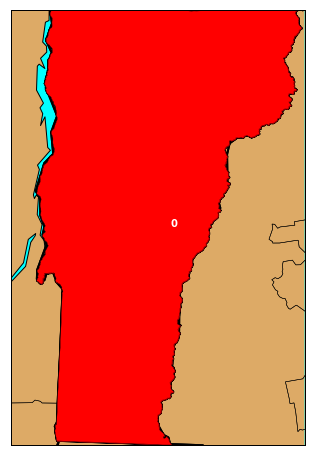

VA


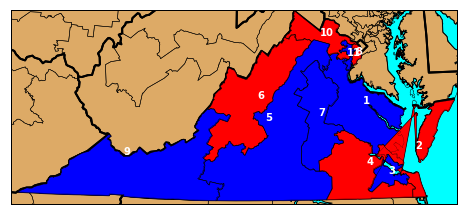

VI


ValueError: Image size of 1941390x1995057 pixels is too large. It must be less than 2^16 in each direction.

WA


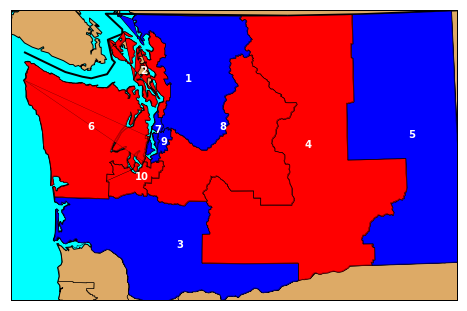

WV


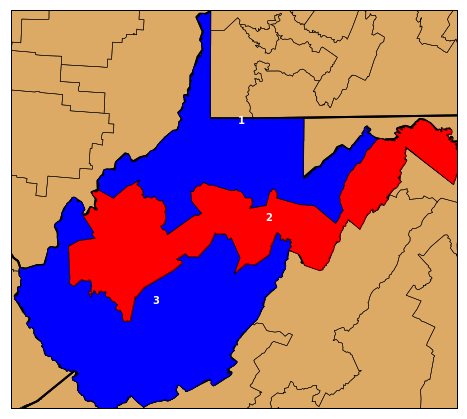

WI


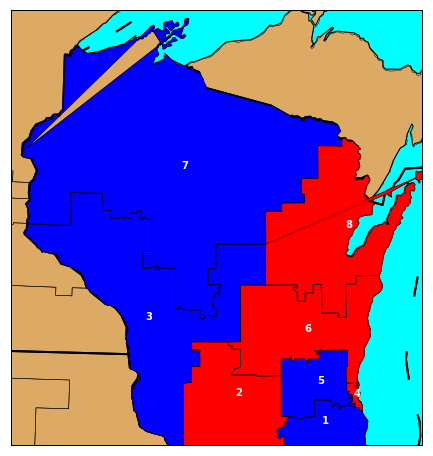

WY


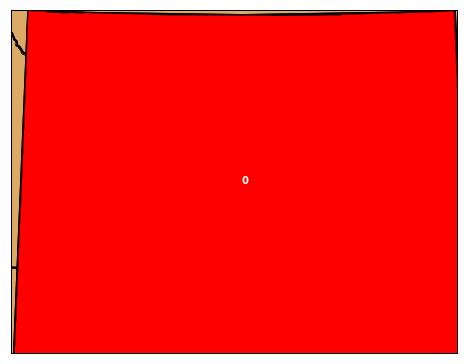

In [176]:
for state in state_coordinates.keys():
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    print(state)
    print_district_map(state, state_coordinates, ax)
    plt.show()